# Identifying toxicity metric

The main goal of this notebook is to identify how to measure toxicity rate of a sentence, what techniquest already exists and whether it's bennificial to use already-existed models.

Prerequirements to run this notebook:
* download all libraries mentioned in `requirements.txt`
* download [filtered ParaNMT-detox corpus dataset](https://github.com/skoltech-nlp/detox/releases/download/emnlp2021/filtered_paranmt.zip)
* unzip archive via graphical interface (ui.py) or just by hands to a directory `../data/raw/filtered_paranmt/filtered.tsv`

Basic information about the dataset
* `reference` (str) - First item from the pair
* `ref_tox` (float) - toxicity level of reference text
* `translation` (str) - second item from the pair - paraphrazed version of the reference
* `trn_tox` (float) - toxicity level of translation text
* `similarity` (float) - cosine similarity of the texts
* `lenght_diff` (float) - relative length difference between texts


In [5]:
import pandas as pd

df = pd.read_table('../data/raw/filtered_paranmt/filtered.tsv', index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


# How initial score was calculated

We can see that dataset already containing toxicity rate columns (`tef_tox` and `trn_tox`). It would be nice if we can calculate toxicity rate the same way as it is in the dataset, so let's deep into it. The first version of the dataset was initially [published](https://aclanthology.org/P18-1042.pdf) by John Wieting and Kevin Gimpel. The dataset contained generated pairs of text. The initial dataset as well as [processed version](https://drive.google.com/file/d/19NQ87gEFYu3zOIp_VNYQZgmnwRuSIyJd/view) do not contain information about toxisity rate and simmilarity.So let's move on.

Next 'layer' is [s-nlp/detox](https://github.com/s-nlp/detox) modification. They made their own version of the dataset based on original [ParaNMT-50m](https://drive.google.com/u/0/uc?id=1rbF3daJjCsa1-fu2GANeJd2FBXos1ugD&export=download) made especiallyfor detoxification. From their github repository we can clearly see that metric they use is based on `SkolkovoInstitute/roberta_toxicity_classifier` and simmilarity rate is `wieting_similarity` (Where `roberta_toxicity_classifier` is fine-tuned [roberta-large](https://arxiv.org/abs/1907.11692) trained on [jigsaw's datasets](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)).

    With this information we can test `s-nlp/detox` values and confirm that we will be working with the same validation scores.

In [6]:
# import all required libraries
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [7]:
# initialize tokenizer and model from s-nlp/detox repository
model_name = 'SkolkovoInstitute/roberta_toxicity_classifier'

tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# load sample batch (cause all data would take ages)
batch_size = 512

sample = df.sample(batch_size)
X = sample.reference.to_list()
y = sample.ref_tox

# run sample batch from tokenizer & model (and calculate results)
tokens = tokenizer(text=X, return_tensors='pt', padding=True)
with torch.inference_mode():
    logits = model(**tokens).logits
result = torch.softmax(logits, -1)[:, 1].cpu().numpy()

<AxesSubplot: ylabel='Frequency'>

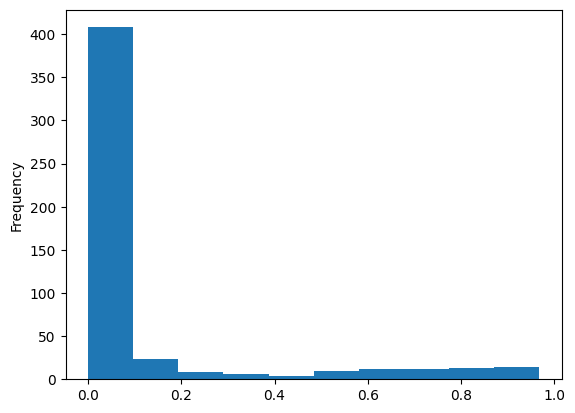

In [9]:
# let's see how diverce our results with actual labels
(result - y).abs().plot.hist()

From the graph we can see that our predictions seems to correlate with real labels, however from batch size 512 not even 400 have error less than `0.1`, which is conserning. We can say that this classifier seems good enough for a task to analyze overall model performance. In addition, we can ingone some samples where values between actual labels and predicted differs a lot by considering that data may be mislabeled. This could also has a potential to provide better performace of model.

# How toxicity measured in other projects

Currently there is no "best solution" for general user-cases, however the most popular choices are [detoxify](https://github.com/unitaryai/detoxify), default hugging face's metric [facebook/roberta-hate-speech-dynabench-r4-target](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target/discussions) and [DaNLP/da-electra-hatespeech-detection](https://huggingface.co/alexandrainst/da-hatespeech-detection-small). For that reason, it would make sence to try all of them and compare them on the same samples with `roberta_toxicity_classifier` from previous block

### Detoxify

A python library for detecting toxic comments. Toxic Comment Classification with Pytorch Lightning and Transformers.

<AxesSubplot: ylabel='Frequency'>

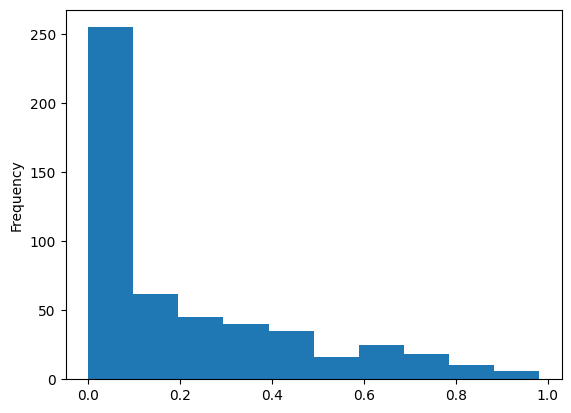

In [10]:
# !pip install detoxify
from detoxify import Detoxify

# define and predict
result = Detoxify('unbiased').predict(X)
result = torch.tensor(result['toxicity'])


(result - y).abs().plot.hist()

### HuggingFace - toxicity default

A `facebook/roberta-hate-speech-dynabench-r4-target` model trained on [Learning from the worst](https://arxiv.org/abs/2012.15761) dataset.

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


<AxesSubplot: ylabel='Frequency'>

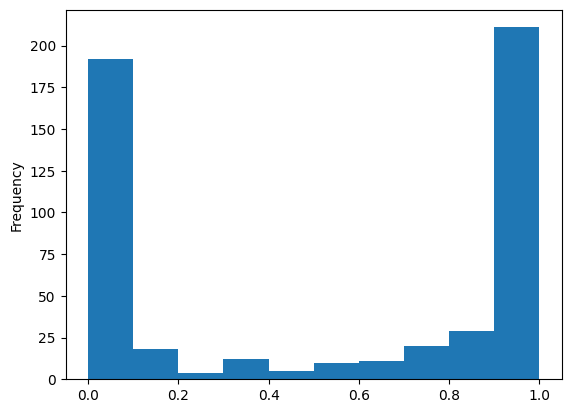

In [11]:
# !pip install -U tensorflow==2.10 
# !pip install evaluate
import evaluate

# initialize and predict
toxicity = evaluate.load("toxicity", module_type="measurement")
result = toxicity.compute(predictions=X)
result = torch.tensor(result['toxicity'])

(result - y).abs().plot.hist()

### HuggingFace - DaNLP

Danish ELECTRA for hate speech (offensive language) detection trained on Danish Ælæctra dataset

<AxesSubplot: ylabel='Frequency'>

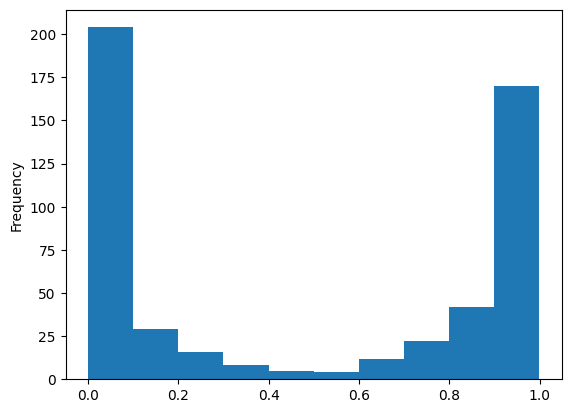

In [13]:
# !pip install -U tensorflow==2.10 
# !pip install evaluate
import evaluate

# initialize and predict
toxicity = toxicity = evaluate.load("toxicity", 'DaNLP/da-electra-hatespeech-detection')
result = toxicity.compute(predictions=X, toxic_label='offensive')
result = torch.tensor(result['toxicity'])

(result - y).abs().plot.hist()

### Model comparison analysis

As we can see by histograms, it's pretty easy to day that `SkolkovoInstitute/roberta_toxicity_classifier` is superior to others. However, worth mentioning that `Detoxify` performed pretty good compared to HuggingFace models and showed pretty strong correlation between it's predictions and unseen labels.

Both `roberta-hate-speech-dynabench-r4-target` and `da-electra-hatespeech-detection` showed uncertanty about the labels, with facebook's model disagreeing with most of the labels. For this reason using these models seems useless as metric. 

# Outcomes of the session

As we can see from the graphs, both `SkolkovoInstitute/roberta_toxicity_classifier` and `Detoxify` seems to correlate the most with dataset. They are both trained on Jigsaw's datasets, when `roberta-hate-speech-dynabench-r4-target` and `a-electra-hatespeech-detection` aren't. Even though `Detoxify` showed worther results on the random samples, it still can be used to identify as metric. 

# Credits

Notebook created by Polina Zelenskaya\
Innopolis University DS21-03

Github: [github.com/cutefluffyfox](https://github.com/cutefluffyfox)\
Email: p.zelenskaya@innopolis.university
